In [26]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob
from random import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    UpSampling2D, add, concatenate, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.19.0
Librosa version: 0.11.0
GPU Available: True


In [3]:
import zipfile
import os

# Path to your zip file
zip_file_path = '/content/drive/MyDrive/song_dataset_standardized.zip' # Update this with the correct path to your zip file

# Directory where you want to extract the contents
extract_dir = '/content/extracted_content'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

print(f"Attempting to unzip {zip_file_path} to {extract_dir}")

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully unzipped {zip_file_path} to {extract_dir}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file or is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Attempting to unzip /content/drive/MyDrive/song_dataset_standardized.zip to /content/extracted_content
Successfully unzipped /content/drive/MyDrive/song_dataset_standardized.zip to /content/extracted_content


In [27]:
# Audio processing parameters
AUDIO_DURATION = 5          # 5 seconds
SAMPLE_RATE = 32000         # 32kHz
WINDOW_SIZE = 1024          # FFT window
HOP_SIZE = 320              # Overlap
MEL_BINS = 64               # Number of mel bands
FRAMES_PER_SEC = SAMPLE_RATE // HOP_SIZE
FRAMES_NUM = FRAMES_PER_SEC * AUDIO_DURATION
AUDIO_SAMPLES = SAMPLE_RATE * AUDIO_DURATION

print(f"Audio samples per file: {AUDIO_SAMPLES}")
print(f"Frames per file: {FRAMES_NUM}")
print(f"Output spectrogram shape: ({FRAMES_NUM}, {MEL_BINS}, 1)")

Audio samples per file: 160000
Frames per file: 500
Output spectrogram shape: (500, 64, 1)


In [28]:
def read_audio(audio_path, target_fs=SAMPLE_RATE):
    """
    Load and preprocess audio file
    """
    try:
        # Load audio
        audio, fs = librosa.load(audio_path, sr=target_fs, mono=True)

        # If stereo, convert to mono
        if audio.ndim > 1:
            audio = np.mean(audio, axis=1)

        return audio, fs
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None, None


def pad_truncate_sequence(audio, max_len):
    """
    Pad or truncate audio to fixed length
    """
    if len(audio) < max_len:
        # Pad with zeros
        audio = np.pad(audio, (0, max_len - len(audio)), mode='constant')
    elif len(audio) > max_len:
        # Take center portion
        center = len(audio) // 2
        start = center - (max_len // 2)
        audio = audio[start:start + max_len]

    return audio


def compute_mel_spectrogram(audio, sr=SAMPLE_RATE, n_fft=WINDOW_SIZE,
                           hop_length=HOP_SIZE, n_mels=MEL_BINS):
    """
    Convert audio to mel spectrogram
    """
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Transpose to (time, frequency)
    log_mel_spec = log_mel_spec.T

    # Normalize to [0, 1]
    log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min() + 1e-8)

    # Add channel dimension
    log_mel_spec = log_mel_spec[..., np.newaxis]

    return log_mel_spec


def audio_to_features(audio_path):
    """
    Complete pipeline: audio file -> mel spectrogram
    """
    # Load audio
    audio, sr = read_audio(audio_path)

    if audio is None:
        return None

    # Pad or truncate to fixed duration
    audio = pad_truncate_sequence(audio, AUDIO_SAMPLES)

    # Convert to mel spectrogram
    mel_spec = compute_mel_spectrogram(audio)

    return mel_spec


print("Audio processing functions defined!")

Audio processing functions defined!


In [29]:
# Genre configuration
GENRES = ['bhojpuri_standardized', 'dohori_standardized', 'newari_standardized', 'rock_standardized', 'tamangselo_standardized']
NUM_CLASSES = len(GENRES)

# Paths
DATASET_PATH = '/content/extracted_content/song_dataset_standardized'
NPZ_OUTPUT_PATH = 'npz_data'

print(f"Genres: {GENRES}")
print(f"Number of classes: {NUM_CLASSES}")

Genres: ['bhojpuri_standardized', 'dohori_standardized', 'newari_standardized', 'rock_standardized', 'tamangselo_standardized']
Number of classes: 5


In [ ]:
def encode_label(genre_name, genres=GENRES):
    label = np.zeros(len(genres))
    idx = genres.index(genre_name)
    label[idx] = 1
    return label


def process_and_save_dataset(dataset_path=DATASET_PATH, output_path=NPZ_OUTPUT_PATH):
    Path(output_path).mkdir(parents=True, exist_ok=True)

    print("="*70)
    print("PROCESSING AUDIO DATASET TO NPZ")
    print("="*70)

    total_processed = 0

    for genre in GENRES:
        genre_path = os.path.join(dataset_path, genre)

        if not os.path.exists(genre_path):
            print(f"\n⚠ Warning: {genre_path} not found!")
            continue

        # Get all audio files
        audio_extensions = ['*.mp3', '*.wav', '*.m4a', '*.webm', '*.flac']
        audio_files = []
        for ext in audio_extensions:
            audio_files.extend(glob(os.path.join(genre_path, ext)))

        print(f"\n{'='*70}")
        print(f"Processing {genre.upper()}: {len(audio_files)} files")
        print(f"{'='*70}")

        # Create genre output directory
        genre_output_path = os.path.join(output_path, genre)
        Path(genre_output_path).mkdir(parents=True, exist_ok=True)

        # Encode label
        label = encode_label(genre)

        # Process each audio file
        for i, audio_file in enumerate(audio_files, 1):
            try:
                # Convert to mel spectrogram
                mel_spec = audio_to_features(audio_file)

                if mel_spec is None:
                    continue

                # Create output filename
                filename = Path(audio_file).stem
                output_file = os.path.join(genre_output_path, f"{filename}.npz")

                # Save as NPZ
                np.savez_compressed(
                    output_file,
                    melgram=mel_spec,
                    target=label
                )

                total_processed += 1

                if i % 10 == 0:
                    print(f"  Processed {i}/{len(audio_files)} files")

            except Exception as e:
                print(f"  ✗ Error processing {Path(audio_file).name}: {e}")
                continue

        print(f"  ✓ Completed {genre}: Saved to {genre_output_path}")

    print(f"\n{'='*70}")
    print(f"PROCESSING COMPLETE!")
    print(f"{'='*70}")
    print(f"Total files processed: {total_processed}")
    print(f"Output location: {os.path.abspath(output_path)}")
    print(f"{'='*70}")

    return total_processed
# Run the processing
num_processed = process_and_save_dataset()

PROCESSING AUDIO DATASET TO NPZ

Processing BHOJPURI_STANDARDIZED: 89 files
  Processed 10/89 files
  Processed 20/89 files
  Processed 30/89 files
  Processed 40/89 files
  Processed 50/89 files
  Processed 60/89 files
  Processed 70/89 files
  Processed 80/89 files
  ✓ Completed bhojpuri_standardized: Saved to npz_data/bhojpuri_standardized

Processing DOHORI_STANDARDIZED: 98 files
  Processed 10/98 files
  Processed 20/98 files
  Processed 30/98 files
  Processed 40/98 files
  Processed 50/98 files
  Processed 60/98 files
  Processed 70/98 files
  Processed 80/98 files
  Processed 90/98 files
  ✓ Completed dohori_standardized: Saved to npz_data/dohori_standardized

Processing NEWARI_STANDARDIZED: 127 files
  Processed 10/127 files
  Processed 20/127 files
  Processed 30/127 files
  Processed 40/127 files
  Processed 50/127 files
  Processed 60/127 files
  Processed 70/127 files
  Processed 80/127 files
  Processed 90/127 files
  Processed 100/127 files
  Processed 110/127 files
  Pr

In [ ]:
class NPZDataGenerator:

    def __init__(self, npz_path=NPZ_OUTPUT_PATH, test_split=0.01, val_split=0.05):
        self.npz_path = npz_path
        self.genres = GENRES
        self.num_classes = NUM_CLASSES

        # Collect all NPZ files
        print("\n" + "="*70)
        print("LOADING NPZ FILES")
        print("="*70)

        all_files = []
        for genre in self.genres:
            genre_files = glob(os.path.join(npz_path, genre, '*.npz'))
            all_files.extend(genre_files)
            print(f"{genre}: {len(genre_files)} files")

        print(f"\nTotal NPZ files: {len(all_files)}")

        # Shuffle files
        shuffle(all_files)

        # Split into train/val/test
        test_size = int(len(all_files) * test_split)
        self.test_files = all_files[:test_size]
        remaining = all_files[test_size:]

        val_size = int(len(remaining) * val_split)
        self.val_files = remaining[:val_size]
        self.train_files = remaining[val_size:]

        print(f"\nData split:")
        print(f"  Training:   {len(self.train_files)} files")
        print(f"  Validation: {len(self.val_files)} files")
        print(f"  Test:       {len(self.test_files)} files")
        print("="*70)

    def _load_and_resize(self, file_path, target_size=(128, 128)):
        try:
            data = np.load(file_path)
            melgram = data['melgram']  # Shape: (500, 64, 1)
            target = data['target']     # Shape: (5,)

            # Remove channel dimension for resizing
            melgram = melgram[:, :, 0]

            # Resize to target size
            h, w = melgram.shape
            resized = np.zeros(target_size)
            resized[:min(h, target_size[0]), :min(w, target_size[1])] = \
                melgram[:min(h, target_size[0]), :min(w, target_size[1])]

            # Add channel dimension back
            resized = resized[..., np.newaxis]

            # Normalize
            resized = (resized - resized.mean()) / (resized.std() + 1e-8)

            return resized, target

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None, None

    def _next_batch(self, batch_size, file_list):
        # Randomly select files
        batch_files = np.random.choice(file_list, size=batch_size, replace=False)

        melgrams = []
        targets = []

        for file_path in batch_files:
            mel, target = self._load_and_resize(file_path)
            if mel is not None:
                melgrams.append(mel)
                targets.append(target)

        return np.array(melgrams), np.array(targets)

    def generator_train(self, batch_size):
        while True:
            yield self._next_batch(batch_size, self.train_files)

    def generator_val(self, batch_size):
        while True:
            yield self._next_batch(batch_size, self.val_files)

    def get_test_data(self, max_samples=None):
        files_to_load = self.test_files[:max_samples] if max_samples else self.test_files

        melgrams = []
        targets = []

        for file_path in files_to_load:
            mel, target = self._load_and_resize(file_path)
            if mel is not None:
                melgrams.append(mel)
                targets.append(target)

        return np.array(melgrams), np.array(targets)


# Create data generator
data_generator = NPZDataGenerator()


LOADING NPZ FILES
bhojpuri_standardized: 89 files
dohori_standardized: 98 files
newari_standardized: 127 files
rock_standardized: 103 files
tamangselo_standardized: 133 files

Total NPZ files: 550

Data split:
  Training:   518 files
  Validation: 27 files
  Test:       5 files


In [32]:
def basic_Block(input, out_filters, strides=(1, 1)):
    """
    Basic residual block
    """
    x = Conv2D(out_filters, kernel_size=(3, 3), strides=strides, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != (1, 1) or input.shape[-1] != out_filters:
        shortcut = Conv2D(out_filters, kernel_size=(1, 1), strides=strides, padding='same')(input)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


def bottleneck_Block(input, out_filters, strides=(1, 1)):
    """
    Bottleneck residual block
    """
    expansion = 4

    x = Conv2D(out_filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters * expansion, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != (1, 1) or input.shape[-1] != out_filters * expansion:
        shortcut = Conv2D(out_filters * expansion, kernel_size=(1, 1), strides=strides, padding='same')(input)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


print("Basic building blocks defined!")

Basic building blocks defined!


In [35]:
def make_branch(x, num_filters, num_blocks):
    """
    Create a branch with multiple basic blocks
    """
    for _ in range(num_blocks):
        x = basic_Block(x, num_filters)
    return x


def fuse_layers(x_list, out_filters_list):
    """
    Fuse multiple resolution branches
    """
    num_branches = len(x_list)
    fused = []

    for i in range(num_branches):
        # For each output branch (target resolution is branch 'i's resolution)
        branch_sum = []

        for j in range(num_branches):
            if j == i:
                # Same resolution
                branch_sum.append(x_list[j])
            elif j < i: # x_list[j] is a HIGHER resolution branch than target i (e.g., x0 (j=0) going into x1 (i=1)) -> need to DOWNSAMPLE
                temp = x_list[j]
                # Downsample step by step (i-j steps of 2x downsampling)
                for k in range(i - j):
                    temp = Conv2D(out_filters_list[i], kernel_size=(3, 3), strides=(2, 2), padding='same')(temp)
                    temp = BatchNormalization()(temp)
                    if k < i - j - 1:  # Don't add ReLU on last layer before fusion
                        temp = Activation('relu')(temp)
                branch_sum.append(temp)
            else: # j > i: # x_list[j] is a LOWER resolution branch than target i (e.g., x1 (j=1) going into x0 (i=0)) -> need to UPSAMPLE
                temp = x_list[j]
                # Upsample step by step (j-i steps of 2x upsampling)
                for k in range(j - i):
                    temp = UpSampling2D(size=(2, 2), interpolation='bilinear')(temp)
                    temp = Conv2D(out_filters_list[i], kernel_size=(1, 1), padding='same')(temp) # Apply Conv1x1 after upsampling to match channels
                    temp = BatchNormalization()(temp)
                    # No activation here, as it's part of fusion, followed by an activation after adding
                branch_sum.append(temp)

        # Add all branches
        if len(branch_sum) > 1:
            fused_branch = add(branch_sum)
        else:
            fused_branch = branch_sum[0]

        fused_branch = Activation('relu')(fused_branch)
        fused.append(fused_branch)

    return fused


print("Fusion layers defined!")

Fusion layers defined!


In [36]:
def build_hrnet(input_shape=(128, 128, 1), num_classes=NUM_CLASSES):
    """
    Build HRNet model for music genre classification
    """
    input_layer = Input(shape=input_shape)

    # Stem: Initial convolution
    x = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stem: Bottleneck blocks
    x = bottleneck_Block(x, 64, strides=(1, 1))
    x = bottleneck_Block(x, 64, strides=(1, 1))
    x = bottleneck_Block(x, 64, strides=(1, 1))
    x = bottleneck_Block(x, 64, strides=(1, 1))

    # Stage 1: Create 2 branches
    x0 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x0 = BatchNormalization()(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # Stage 1: Process branches
    x0 = make_branch(x0, 32, num_blocks=4)
    x1 = make_branch(x1, 64, num_blocks=4)

    # Stage 1: Fusion
    x0, x1 = fuse_layers([x0, x1], [32, 64])

    # Stage 2: Add 3rd branch
    x2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    # Stage 2: Process branches
    x0 = make_branch(x0, 32, num_blocks=4)
    x1 = make_branch(x1, 64, num_blocks=4)
    x2 = make_branch(x2, 128, num_blocks=4)

    # Stage 2: Fusion
    x0, x1, x2 = fuse_layers([x0, x1, x2], [32, 64, 128])

    # Stage 3: Add 4th branch
    x3 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same')(x2)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    # Stage 3: Process branches
    x0 = make_branch(x0, 32, num_blocks=4)
    x1 = make_branch(x1, 64, num_blocks=4)
    x2 = make_branch(x2, 128, num_blocks=4)
    x3 = make_branch(x3, 256, num_blocks=4)

    # Final fusion: Combine all branches to highest resolution
    # Upsample all to x0 resolution
    x1_up = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    x1_up = Conv2D(32, kernel_size=(1, 1), padding='same')(x1_up)

    x2_up = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    x2_up = Conv2D(32, kernel_size=(1, 1), padding='same')(x2_up)

    x3_up = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    x3_up = Conv2D(32, kernel_size=(1, 1), padding='same')(x3_up)

    # Concatenate all
    x = concatenate([x0, x1_up, x2_up, x3_up])

    # Final convolution
    x = Conv2D(128, kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=input_layer, outputs=output, name='HRNet_Music_Genre')

    return model


# Build model
model = build_hrnet()

print("\n" + "="*70)
print("HRNET MODEL ARCHITECTURE")
print("="*70)
model.summary()
print(f"\n✓ Total parameters: {model.count_params():,}")


HRNET MODEL ARCHITECTURE


Model: "HRNet_Music_Genre"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 64, 64,    │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 64, 64,    │      4,160 │ activation_63[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_64[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 64, 64,    │     16,640 │ activation_65[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 64, 64,    │     16,640 │ activation_63[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_73[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 64, 64,    │          0 │ add_26[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 64, 64,    │     16,448 │ activation_66[0]

 Total params: 9,448,453 (36.04 MB)

 Trainable params: 9,429,317 (35.97 MB)

 Non-trainable params: 19,136 (74.75 KB)


✓ Total parameters: 9,448,453


In [37]:
# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


In [38]:
# Setup callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'music_genre_hrnet_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    CSVLogger('training_log.csv')
]

print("Callbacks configured:")
print("  ✓ EarlyStopping: patience=10")
print("  ✓ ModelCheckpoint: saves best model")
print("  ✓ ReduceLROnPlateau: reduces LR on plateau")
print("  ✓ CSVLogger: logs training metrics")

Callbacks configured:
  ✓ EarlyStopping: patience=10
  ✓ ModelCheckpoint: saves best model
  ✓ ReduceLROnPlateau: reduces LR on plateau
  ✓ CSVLogger: logs training metrics


In [39]:
# Training parameters
BATCH_SIZE = 16
EPOCHS = 50
STEPS_PER_EPOCH = len(data_generator.train_files) // BATCH_SIZE
VALIDATION_STEPS = len(data_generator.val_files) // BATCH_SIZE

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")
print("="*70)

# Train model
history = model.fit(
    data_generator.generator_train(BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=data_generator.generator_val(BATCH_SIZE),
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)


STARTING TRAINING
Batch size: 16
Epochs: 50
Steps per epoch: 32
Validation steps: 1
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.2580 - loss: 1.6944
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to music_genre_hrnet_best.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 603ms/step - accuracy: 0.2583 - loss: 1.6917 - val_accuracy: 0.0625 - val_loss: 52.2603 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.3941 - loss: 1.4651
Epoch 2: val_accuracy improved from 0.06250 to 0.12500, saving model to music_genre_hrnet_best.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.3937 - loss: 1.4649 - val_accuracy: 0.1250 - val_loss: 4.2480 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3341 - loss: 1.5087
Epoch 3: val_accuracy did not improve from 0.12500
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.3348 - loss: 1.5078 - val_accuracy: 0.0625 - val_loss: 2.1267 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4150 - loss: 1.3804
Epoch 4: val_accuracy improved from 0.12500 to 0.37500, saving model to music_genre_hrnet_best.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.4146 - loss: 1.3817 - val_accuracy: 0.3750 - val_loss: 13.9224 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4140 - loss: 1.4280
Epoch 5: val_accuracy did not improve from 0.37500
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.4147 - loss: 1.4274 - val_accuracy: 0.0625 - val_loss: 2.9895 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4644 - loss: 1.3080
Epoch 6: val_accuracy did not improve from 0.37500
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.4637 - loss: 1.3095 - val_accuracy: 0.0625 - val_loss: 5.2274 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4499 - loss: 1.2971
Epoch 7: val_accuracy did not improve from 0.37500
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.4508 - loss: 1.2969 - val_accuracy: 0.0625 - val_loss: 2.3740 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.6304 - loss: 0.9096 - val_accuracy: 0.4375 - val_loss: 1.5759 - learning_rate: 5.0000e-04
Epoch 22/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6599 - loss: 0.8445
Epoch 22: val_accuracy did not improve from 0.43750
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.6597 - loss: 0.8448 - val_accuracy: 0.3750 - val_loss: 1.5236 - learning_rate: 5.0000e-04
Epoch 23/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7001 - loss: 0.7374
Epoch 23: val_accuracy did not improve from 0.43750
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.7012 - loss: 0.7355 - val_accuracy: 0.1875 - val_loss: 2.1880 - learning_rate: 5.0000e-04
Epoch 24/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7348 - loss: 0.7246
Epoch 24: val_accuracy did not improve from 0.43750
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.7349 - loss: 0.7243 - val_accuracy: 0.4375 - val_loss: 1.3278 - learning_rate: 5.0000e-04
Epo


Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.7643 - loss: 0.6344 - val_accuracy: 0.5000 - val_loss: 1.5158 - learning_rate: 5.0000e-04
Epoch 30/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8664 - loss: 0.4472
Epoch 30: val_accuracy did not improve from 0.50000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.8663 - loss: 0.4467 - val_accuracy: 0.2500 - val_loss: 1.6995 - learning_rate: 2.5000e-04
Epoch 31/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8800 - loss: 0.3811
Epoch 31: val_accuracy did not improve from 0.50000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.8803 - loss: 0.3810 - val_accuracy: 0.2500 - val_loss: 2.0768 - learning_rate: 2.5000e-04
Epoch 32/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8901 - loss: 0.3821
Epoch 32: val_accuracy did not improve from 0.50000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.8897 - loss: 0.

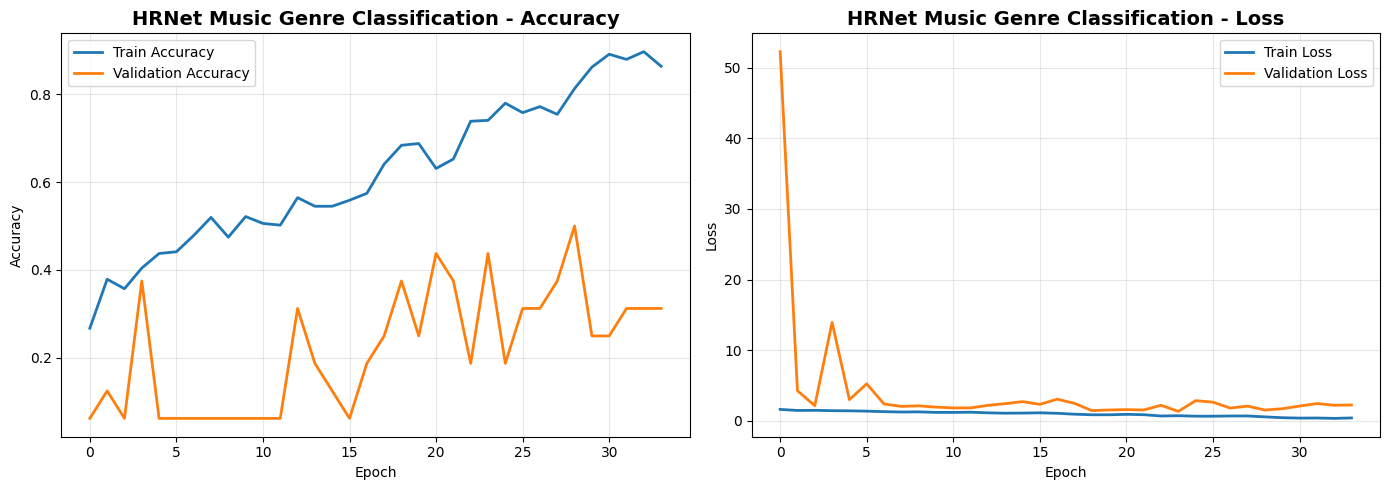


FINAL TRAINING RESULTS
Final Training Accuracy:   0.8633
Final Validation Accuracy: 0.3125
Final Training Loss:       0.3965
Final Validation Loss:     2.2269


In [41]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('HRNet Music Genre Classification - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('HRNet Music Genre Classification - Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n" + "="*70)
print("FINAL TRAINING RESULTS")
print("="*70)
print(f"Final Training Accuracy:   {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss:       {final_train_loss:.4f}")
print(f"Final Validation Loss:     {final_val_loss:.4f}")
print("="*70)

In [42]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('music_genre_hrnet_best.h5')

# Get test data from the generator
X_test, y_test = data_generator.get_test_data()

print("\n" + "="*70)
print("EVALUATING music_genre_hrnet_best.h5 MODEL ON TEST DATA")
print("="*70)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("="*70)


EVALUATING MODEL ON TEST DATA
Test Loss: 1.1267
Test Accuracy: 0.6000


In [43]:
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Validation Accuracy: 0.3125


In [44]:
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")

Training Accuracy: 0.8633


In [45]:
print(f"Training Loss: {history.history['loss'][-1]:.4f}")

Training Loss: 0.3965


In [46]:
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

Validation Loss: 2.2269


In [1]:
import pandas as pd

# Load training history from CSV (automatically saved during training)
log = pd.read_csv('training_log.csv')

print("="*70)
print("MODEL PERFORMANCE FROM TRAINING HISTORY")
print("="*70)

# Get final epoch values
final_train_acc = log['accuracy'].iloc[-1]
final_val_acc = log['val_accuracy'].iloc[-1]
final_train_loss = log['loss'].iloc[-1]
final_val_loss = log['val_loss'].iloc[-1]

# Get best values
best_train_acc = log['accuracy'].max()
best_val_acc = log['val_accuracy'].max()
best_train_loss = log['loss'].min()
best_val_loss = log['val_loss'].min()

print("\nFINAL EPOCH:")
print(f"  Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"  Training Loss:       {final_train_loss:.4f}")
print(f"  Validation Loss:     {final_val_loss:.4f}")

print("\nBEST VALUES:")
print(f"  Best Training Accuracy:   {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"  Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Best Training Loss:       {best_train_loss:.4f}")
print(f"  Best Validation Loss:     {best_val_loss:.4f}")

print("="*70)

MODEL PERFORMANCE FROM TRAINING HISTORY

FINAL EPOCH:
  Training Accuracy:   0.8633 (86.33%)
  Validation Accuracy: 0.3125 (31.25%)
  Training Loss:       0.3965
  Validation Loss:     2.2269

BEST VALUES:
  Best Training Accuracy:   0.8965 (89.65%)
  Best Validation Accuracy: 0.5000 (50.00%)
  Best Training Loss:       0.3343
  Best Validation Loss:     1.3278


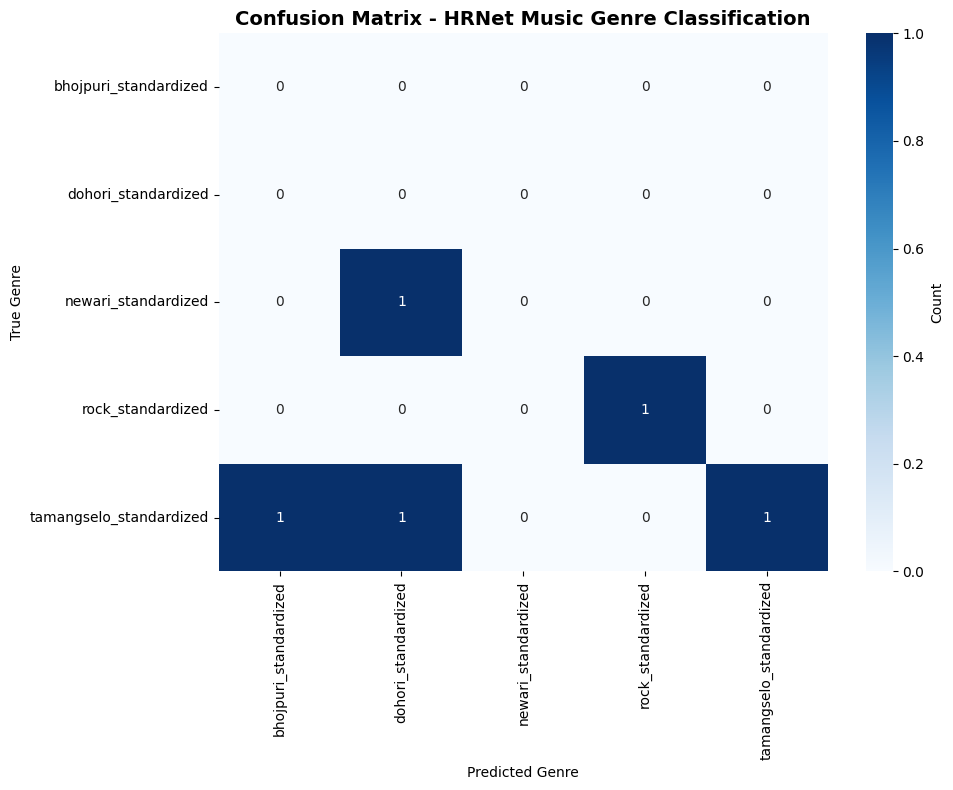


CLASSIFICATION REPORT
                         precision    recall  f1-score   support

  bhojpuri_standardized       0.00      0.00      0.00         0
    dohori_standardized       0.00      0.00      0.00         0
    newari_standardized       0.00      0.00      0.00         1
      rock_standardized       1.00      1.00      1.00         1
tamangselo_standardized       1.00      0.33      0.50         3

               accuracy                           0.40         5
              macro avg       0.40      0.27      0.30         5
           weighted avg       0.80      0.40      0.50         5


PER-GENRE ACCURACY
Newari_standardized: 0.0000 (0/1)
Rock_standardized: 1.0000 (1/1)
Tamangselo_standardized: 0.3333 (1/3)


In [52]:
# Get predictions
y_pred = model.predict(test_X, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_y, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=GENRES, yticklabels=GENRES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - HRNet Music Genre Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Genre')
plt.xlabel('Predicted Genre')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true_classes, y_pred_classes, target_names=GENRES))

# Per-genre accuracy
print("\n" + "="*70)
print("PER-GENRE ACCURACY")
print("="*70)
for i, genre in enumerate(GENRES):
    if cm[i].sum() > 0:
        genre_acc = cm[i, i] / cm[i].sum()
        print(f"{genre.capitalize():15s}: {genre_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")
print("="*70)

CONFUSION MATRIX GENERATION

Loading model...


✅ Model loaded

Loading validation data...
Validation samples: 27

Generating predictions...



Validation Accuracy: 0.4815 (48.15%)


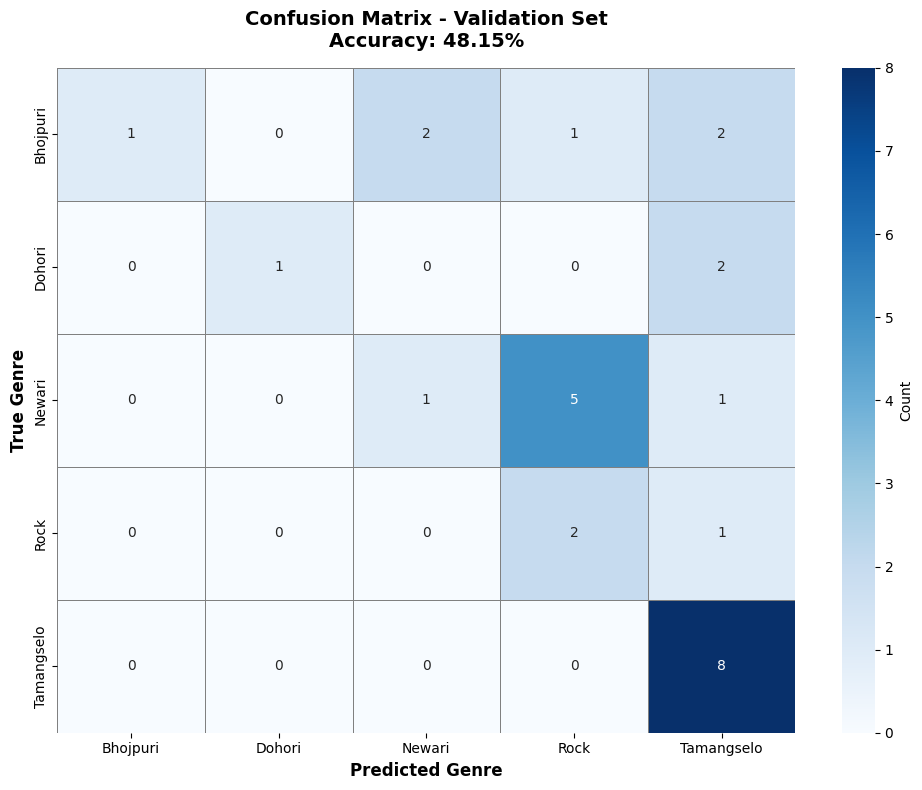


✅ Confusion matrix saved: confusion_matrix.png

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Bhojpuri     1.0000    0.1667    0.2857         6
      Dohori     1.0000    0.3333    0.5000         3
      Newari     0.3333    0.1429    0.2000         7
        Rock     0.2500    0.6667    0.3636         3
  Tamangselo     0.5714    1.0000    0.7273         8

    accuracy                         0.4815        27
   macro avg     0.6310    0.4619    0.4153        27
weighted avg     0.6168    0.4815    0.4268        27


PER-GENRE ACCURACY
Bhojpuri    : 0.1667 ( 16.67%) -   1/  6 correct
Dohori      : 0.3333 ( 33.33%) -   1/  3 correct
Newari      : 0.1429 ( 14.29%) -   1/  7 correct
Rock        : 0.6667 ( 66.67%) -   2/  3 correct
Tamangselo  : 1.0000 (100.00%) -   8/  8 correct


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Configuration
GENRES = ['bhojpuri_standardized', 'dohori_standardized', 'newari_standardized',
          'rock_standardized', 'tamangselo_standardized']

print("="*70)
print("CONFUSION MATRIX GENERATION")
print("="*70)

# Load model
print("\nLoading model...")
model = load_model('music_genre_hrnet_best.h5')
print("✅ Model loaded")

# Get validation data from existing data_generator
print("\nLoading validation data...")
X_val = []
y_val = []

for file_path in data_generator.val_files:
    mel, target = data_generator._load_and_resize(file_path)
    if mel is not None:
        X_val.append(mel)
        y_val.append(target)

X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"Validation samples: {len(X_val)}")

# Get predictions
print("\nGenerating predictions...")
y_pred = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Calculate accuracy
val_accuracy = np.mean(y_pred_classes == y_true_classes)

print("\n" + "="*70)
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("="*70)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
genre_labels = [g.replace('_standardized', '').capitalize() for g in GENRES]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_labels, yticklabels=genre_labels,
            cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')

plt.title(f'Confusion Matrix - Validation Set\nAccuracy: {val_accuracy:.2%}',
          fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Genre', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Genre', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix saved: confusion_matrix.png")

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=genre_labels, digits=4))

# Per-genre accuracy
print("\n" + "="*70)
print("PER-GENRE ACCURACY")
print("="*70)

for i, genre in enumerate(genre_labels):
    if cm[i].sum() > 0:
        genre_acc = cm[i, i] / cm[i].sum()
        correct = cm[i, i]
        total = cm[i].sum()
        print(f"{genre:12s}: {genre_acc:.4f} ({genre_acc*100:6.2f}%) - {correct:3d}/{total:3d} correct")

print("="*70)